In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create working directory
import os
WORKDIR = "/content/drive/MyDrive/image_retrieval_phase1"
os.makedirs(WORKDIR, exist_ok=True)
print("Workdir:", WORKDIR)

# Install core deps
!pip install -q torch torchvision transformers timm scikit-learn pandas tqdm kagglehub[pandas-datasets]
!pip install faiss-cpu --no-cache-dir


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Workdir: /content/drive/MyDrive/image_retrieval_phase1


In [ ]:
# Mount Google Drive


WORKDIR = "/content/drive/MyDrive/image_retrieval_phase1_coco"
!mkdir -p "$WORKDIR"

# Core installs
!pip install -q torch torchvision timm transformers scikit-learn pandas tqdm kagglehub faiss-cpu


In [ ]:
from torchvision.datasets import CocoCaptions
import os, pandas as pd
from tqdm import tqdm
import kagglehub

# Download COCO 2017 via KaggleHub
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print(f"\nPath to Dataset Files: {path}")

coco2017_path = os.path.join(path, "coco2017")
coco_root = os.path.join(coco2017_path, "train2017")
ann_file = os.path.join(coco2017_path, "annotations", "captions_train2017.json")
train_csv_path = os.path.join(WORKDIR, "dataset_train.csv")

# Build or load cached CSV of (image_path, text)
if not os.path.exists(train_csv_path):
    coco = CocoCaptions(root=coco_root, annFile=ann_file)
    image_paths, texts = [], []

    for idx in tqdm(range(len(coco)), desc="Processing COCO Captions"):
        _, captions = coco[idx]
        img_file = coco.coco.imgs[coco.ids[idx]]["file_name"]
        img_path = os.path.join(coco_root, img_file)
        for cap in captions:
            image_paths.append(img_path)
            texts.append(cap)

    df_train = pd.DataFrame({"image_path": image_paths, "text": texts})
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    df_train.to_csv(train_csv_path, index=False)
    print(f"\nSaved CSV → {train_csv_path}")
else:
    print(f"\nCSV Already Exists → {train_csv_path}")
    df_train = pd.read_csv(train_csv_path)

print("Sample rows:\n", df_train.head())


100%|██████████| 25.0G/25.0G [08:08<00:00, 55.1MB/s]

Extracting files...



Path to Dataset Files: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2
loading annotations into memory...
Done (t=1.36s)
creating index...
index created!


Processing COCO Captions: 100%|██████████| 118287/118287 [08:26<00:00, 233.49it/s]



Saved CSV → /content/drive/MyDrive/image_retrieval_phase1_coco/dataset_train.csv
Sample rows:
                                           image_path  \
0  /root/.cache/kagglehub/datasets/awsaf49/coco-2...   
1  /root/.cache/kagglehub/datasets/awsaf49/coco-2...   
2  /root/.cache/kagglehub/datasets/awsaf49/coco-2...   
3  /root/.cache/kagglehub/datasets/awsaf49/coco-2...   
4  /root/.cache/kagglehub/datasets/awsaf49/coco-2...   

                                                text  
0     a man skiing on very high snow near some trees  
1  A married couple in a spotlight with a wedding...  
2      Two men playing with a Frisbee at the beach.   
3     Three people holding a racehorse on the track.  
4  Three young ladies are smiling under the red u...  


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import AutoTokenizer
from PIL import Image
import torch, random

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

class CocoDataset(Dataset):
    def __init__(self, df, tokenizer, img_transform, num_neg=5, max_len=40):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_transform = img_transform
        self.num_neg = num_neg
        self.max_len = max_len

        self.texts = self.df["text"].astype(str).tolist()
        self.img_paths = self.df["image_path"].tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = self.img_transform(Image.open(row["image_path"]).convert("RGB"))
        pos = str(row["text"])

        # random negatives
        negs = random.sample(self.texts, k=self.num_neg)
        texts = [pos] + negs

        toks = self.tokenizer(
            texts, padding="max_length", truncation=True,
            max_length=self.max_len, return_tensors="pt"
        )
        return {
            "pixel_values": img,
            "input_ids": toks["input_ids"],
            "attention_mask": toks["attention_mask"],
            "pos_index": 0
        }


In [ ]:
import torch.nn as nn
from timm.models.vision_transformer import vit_tiny_patch16_224

class SimpleTextEncoder(nn.Module):
    def __init__(self, vocab, dim=256, layers=4, heads=4):
        super().__init__()
        self.embed = nn.Embedding(vocab, dim)
        enc_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.pool = lambda x, m: (x * m.unsqueeze(-1)).sum(1) / m.sum(1, keepdim=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, ids, mask):
        x = self.embed(ids)
        x = self.encoder(x)
        pooled = self.pool(x, mask)
        return nn.functional.normalize(self.proj(pooled), dim=-1)

class SimpleImageEncoder(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.vit = vit_tiny_patch16_224(pretrained=False)
        self.proj = nn.Linear(self.vit.embed_dim, dim)
    def forward(self, pixels):
        feat = self.vit.forward_features(pixels)[:,0]
        return nn.functional.normalize(self.proj(feat), dim=-1)

class BiEncoder(nn.Module):
    def __init__(self, vocab_size, dim=256):
        super().__init__()
        self.text_encoder = SimpleTextEncoder(vocab_size, dim)
        self.img_encoder = SimpleImageEncoder(dim)
        self.temp = nn.Parameter(torch.tensor(0.07))
    def forward(self, pixels, ids, mask):
        t = self.text_encoder(ids, mask)
        i = self.img_encoder(pixels)
        return t, i, self.temp


In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

def contrastive_loss(t, i, temp):
    sim = (t @ i.T) / temp
    labels = torch.arange(len(t), device=t.device)
    return (F.cross_entropy(sim, labels) + F.cross_entropy(sim.T, labels)) / 2

def train_one_epoch(model, loader, opt, device):
    model.train(); tot=0
    for b in tqdm(loader):
        pix = b["pixel_values"].to(device)
        ids = b["input_ids"][:,0,:].to(device)
        mask = b["attention_mask"][:,0,:].to(device)
        t,i,temp = model(pix, ids, mask)
        loss = contrastive_loss(t,i,temp)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()
    return tot/len(loader)


In [ ]:
import faiss, numpy as np

def build_index(img_emb):
    dim = img_emb.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(img_emb.astype("float32"))
    return index

def evaluate(model, loader, device, k=[1,5,10]):
    model.eval(); texts, imgs = [], []
    with torch.no_grad():
        for b in tqdm(loader):
            pv = b["pixel_values"].to(device)
            ids = b["input_ids"][:,0,:].to(device)
            mask = b["attention_mask"][:,0,:].to(device)
            t,i,_ = model(pv, ids, mask)
            texts.append(t.cpu()); imgs.append(i.cpu())
    texts = torch.cat(texts).numpy(); imgs = torch.cat(imgs).numpy()
    idx = build_index(imgs)
    _, I = idx.search(texts, max(k))
    return {f"R@{x}": np.mean(np.any(I[:,:x]==np.arange(len(I))[:,None],1)) for x in k}


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Use a manageable fraction for quick test
df_small = df_train.sample(frac=0.3, random_state=42)
dataset = CocoDataset(df_small, tokenizer, img_transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

model = BiEncoder(tokenizer.vocab_size, 256).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

for ep in range(3):  # short run
    loss = train_one_epoch(model, loader, opt, device)
    print(f"Epoch {ep+1} loss {loss:.4f}")

torch.save(model.state_dict(), os.path.join(WORKDIR, "baseline_coco_5pct.pt"))


100%|██████████| 11096/11096 [31:42<00:00,  5.83it/s]


Epoch 1 loss 2.2733


100%|██████████| 11096/11096 [32:09<00:00,  5.75it/s]


Epoch 2 loss 1.6758


100%|██████████| 11096/11096 [31:59<00:00,  5.78it/s]


Epoch 3 loss 1.4194


In [ ]:
metrics = evaluate(model, loader, device)
print("Baseline metrics:", metrics)


100%|██████████| 11096/11096 [28:39<00:00,  6.45it/s]


Baseline metrics: {'R@1': np.float64(0.00038304248391784866), 'R@5': np.float64(0.002072935795320122), 'R@10': np.float64(0.0038754886608158806)}


In [ ]:
# === Phase 2: QuRE Hard-Negative Training (run AFTER Phase-1 cells) ===

import os, math, random, pickle
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Hyperparams (tweakable)
DATA_FRACTION = 0.05   # ensure df_small was created using this fraction in Phase-1
NEPOCH = 8             # number of QuRE epochs (small quick run)
NDEF = 4               # recompute H sets every floor(NEPOCH/NDEF) epochs (paper-like)
BATCH_SIZE = 16
NEG_PER_QUERY = 1      # sample 1 negative per query as in QuRE
TOPK_FALLBACK = 5000   # if num_images > TOPK_FALLBACK_USE_FAISS, use FAISS top-K to approximate ranking
TOPK_FALLBACK_USE_FAISS = 20000  # threshold of num_images to decide FAISS usage
H_SAVE_DIR = os.path.join(WORKDIR, "hard_negatives")
os.makedirs(H_SAVE_DIR, exist_ok=True)
CKPT_DIR = os.path.join(WORKDIR, "checkpoints_qure")
os.makedirs(CKPT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
# Prepare unique images (corpus) and mappings
unique_images = df_train['image_path'].unique().tolist()
num_images = len(unique_images)
img2idx = {p: i for i,p in enumerate(unique_images)}
# Add target image index column to df_train (if not already)
if 'target_idx' not in df_train.columns:
    df_train['target_idx'] = df_train['image_path'].map(img2idx)

# Use df_small (5% training subset) as the training set for QuRE
df_small = df_train.sample(frac=DATA_FRACTION, random_state=42).reset_index(drop=True)
print(f"Num corpus images: {num_images}, training rows used: {len(df_small)}")


Num corpus images: 118287, training rows used: 29588


In [ ]:
def compute_image_embeddings(model, image_paths, batch_size=64, device=device, force_recompute=False, cache_path=None):
    """
    Compute (and optionally cache) normalized image embeddings for a list of image_paths.
    Returns: numpy array shape (N_images, D)
    """
    if cache_path is None:
        cache_path = os.path.join(WORKDIR, "image_embs.npy")
    if (not force_recompute) and os.path.exists(cache_path):
        try:
            embs = np.load(cache_path)
            if embs.shape[0] == len(image_paths):
                print("Loaded cached image embeddings:", cache_path)
                return embs
        except:
            pass

    model.eval()
    embs_list = []
    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding images"):
            batch_paths = image_paths[i:i+batch_size]
            imgs = []
            for p in batch_paths:
                imgs.append(img_transform(Image.open(p).convert("RGB")))
            imgs = torch.stack(imgs).to(device)
            emb = model.img_encoder(imgs)   # returns normalized embeddings (torch.Tensor)
            embs_list.append(emb.cpu())
    embs = torch.cat(embs_list, dim=0).numpy().astype("float32")
    np.save(cache_path, embs)
    print("Saved image embeddings to:", cache_path)
    return embs

# initial compute (cache allowed)
image_embs_path = os.path.join(WORKDIR, "image_embs_qure.npy")
image_embs = compute_image_embeddings(model, unique_images, batch_size=64, device=device, force_recompute=False, cache_path=image_embs_path)
print("image_embs shape:", image_embs.shape)


Encoding images: 100%|██████████| 1849/1849 [23:21<00:00,  1.32it/s]


Saved image embeddings to: /content/drive/MyDrive/image_retrieval_phase1_coco/image_embs_qure.npy
image_embs shape: (118287, 256)


In [ ]:
def compute_query_embeddings(model, texts, batch_size=128, device=device):
    """
    Returns numpy array of shape (N_queries, D)
    """
    model.eval()
    q_list = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            toks = tokenizer(batch_texts, padding=True, truncation=True, max_length=40, return_tensors="pt")
            ids = toks['input_ids'].to(device)
            attn = toks['attention_mask'].to(device)
            q_emb = model.text_encoder(ids, attn)  # torch tensor normalized
            q_list.append(q_emb.cpu())
    q_embs = torch.cat(q_list, dim=0).numpy().astype("float32")
    return q_embs


In [ ]:
def compute_H_from_scores(scores, targ_idx, min_window=10, fallback_window=50):
    """
    scores: 1D numpy array of similarity scores for all images (length N_images)
    targ_idx: integer index of the target image in the image corpus
    Returns list of image indices (H)
    """
    # sort images by descending score
    order = np.argsort(-scores)   # indices sorted by score desc
    # position of target
    pos = np.where(order == targ_idx)[0]
    if len(pos) == 0:
        # target not found — fallback
        return []
    pos = pos[0]
    # suffix after target
    if pos+1 >= len(order):
        return []
    suffix_idx = order[pos+1:]
    suffix_scores = scores[suffix_idx]
    if len(suffix_scores) < min_window:
        # not enough elements — fallback to small window after target
        start = pos+1
        end = min(len(order), pos+1+fallback_window)
        return order[start:end].tolist()
    # compute successive drops in the suffix: drop_j = s_j - s_{j+1}
    drops = suffix_scores[:-1] - suffix_scores[1:]
    # find top-2 drop positions (relative to suffix)
    top2 = np.argsort(-drops)[:2]
    if top2.size < 2:
        # fallback
        start = pos+1
        end = min(len(order), pos+1+fallback_window)
        return order[start:end].tolist()
    k1, k2 = int(np.min(top2)), int(np.max(top2))
    # H is images between the two largest drops (exclusive/inclusive per adaptation)
    # we choose images between indices (pos+1 + min(k1,k2)+1) .. (pos+1 + max(k1,k2)+1) inclusive of start, exclusive of end
    start = pos + 1 + min(k1, k2) + 1
    end = pos + 1 + max(k1, k2) + 1
    if start >= end:
        # fallback to small window
        start = pos+1
        end = min(len(order), pos+1+fallback_window)
    H = order[start:end].tolist()
    return H


In [ ]:
import faiss

def compute_all_H_sets(model, df_for_queries, unique_images, image_embs, use_faiss_if_large=True, topk_faiss=5000):
    """
    Returns H_sets: list of lists where H_sets[i] is H for df_for_queries.iloc[i]
    df_for_queries: DataFrame with 'text' and 'target_idx' columns
    """
    print("Computing query embeddings...")
    texts = df_for_queries['text'].astype(str).tolist()
    q_embs = compute_query_embeddings(model, texts, batch_size=128, device=device)  # Nq x D
    Nq, Nid = q_embs.shape[0], image_embs.shape[0]
    H_sets = [None] * Nq

    # Decide whether to use FAISS top-K to approximate full sort
    use_faiss = use_faiss_if_large and (Nid >= TOPK_FALLBACK_USE_FAISS)
    if use_faiss:
        print("Using FAISS top-K fallback for ranking (topk =", topk_faiss, ")")
        index = faiss.IndexFlatIP(image_embs.shape[1])
        index.add(image_embs)  # image_embs must be float32
        # For each query, get top-(topk_faiss + margin) indices and their scores, then apply QuRE logic on those.
        batch = 256
        for i in tqdm(range(0, Nq, batch), desc="FAISS querying"):
            qchunk = q_embs[i:i+batch].astype("float32")
            k = min(topk_faiss, Nid)
            D, I = index.search(qchunk, k)   # D: similarities, I: indices
            for j in range(qchunk.shape[0]):
                global_idx = i + j
                # We need full ranking to find drops after the target. If target not in top-K, fallback: use top-K as suffix
                target_idx = int(df_for_queries.iloc[global_idx]['target_idx'])
                # Build a fake 'scores' vector of length = k where positions correspond to returned I[]
                # We'll run compute_H_from_scores on this reduced ranking by mapping target presence
                scores_small = D[j]
                idxs_small = I[j]
                # If target not present, append the target by computing its score explicitly and include in list
                if target_idx not in idxs_small:
                    targ_emb = image_embs[target_idx].astype("float32")
                    targ_score = (qchunk[j] @ targ_emb.T).item()
                    # insert target into ranks
                    idxs_aug = np.concatenate([idxs_small, np.array([target_idx], dtype=np.int64)])
                    scores_aug = np.concatenate([scores_small, np.array([targ_score], dtype=np.float32)])
                else:
                    idxs_aug = idxs_small
                    scores_aug = scores_small
                # Now create a temp score array of length Nid filled with very low values, then fill top-K positions
                # but compute_H_from_scores expects full vector; we'll instead adapt logic: operate on the reduced ranking
                # Build a mapping from reduced order to full indices and apply adapted compute_H_from_scores on reduced set
                # Adaptation: treat scores_aug as full ranking and run the same drop logic
                order_reduced = np.argsort(-scores_aug)
                # find position of target in reduced order
                pos = np.where(order_reduced == np.where(idxs_aug == target_idx)[0][0])[0][0]
                # compute H on reduced ranking using drop logic on scores_aug[order_reduced]
                suffix_scores = scores_aug[order_reduced][pos+1:]
                if len(suffix_scores) < 3:
                    # fallback to next window indices from reduced order
                    start = pos+1
                    end = min(len(order_reduced), pos+1+50)
                    H_reduced = order_reduced[start:end]
                else:
                    drops = suffix_scores[:-1] - suffix_scores[1:]
                    top2 = np.argsort(-drops)[:2]
                    if top2.size < 2:
                        start = pos+1
                        end = min(len(order_reduced), pos+1+50)
                        H_reduced = order_reduced[start:end]
                    else:
                        k1, k2 = int(np.min(top2)), int(np.max(top2))
                        start = pos+1 + min(k1,k2) + 1
                        end = pos+1 + max(k1,k2) + 1
                        if start >= end:
                            start = pos+1
                            end = min(len(order_reduced), pos+1+50)
                        H_reduced = order_reduced[start:end]
                # Map reduced H indices back to global image indices
                H_global = idxs_aug[H_reduced].tolist()
                H_sets[global_idx] = H_global
    else:
        print("Using full-dot product ranking (no FAISS).")
        # Do in chunks to avoid memory blow up
        chunk_q = 256
        for i in tqdm(range(0, Nq, chunk_q), desc="Computing full scores in chunks"):
            qchunk = q_embs[i:i+chunk_q]  # shape (batch_q, D)
            # compute qchunk @ image_embs.T  -> shape (batch_q, Nid)
            scores_chunk = qchunk @ image_embs.T  # numpy matmul
            for j in range(scores_chunk.shape[0]):
                global_idx = i + j
                scores = scores_chunk[j]
                targ_idx = int(df_for_queries.iloc[global_idx]['target_idx'])
                H = compute_H_from_scores(scores, targ_idx)
                if len(H) == 0:
                    # fallback: choose next 50 images after target in ranking
                    order = np.argsort(-scores)
                    pos = np.where(order == targ_idx)[0][0]
                    H = order[pos+1:pos+51].tolist()
                H_sets[global_idx] = H
    return H_sets


Loaded cached image embeddings: /content/drive/MyDrive/image_retrieval_phase1_coco/image_embs_qure.npy

=== QuRE epoch 1 / 8 ===
Warmup epoch: sampling negatives uniformly from corpus (no H sets).


Training batches: 100%|██████████| 1850/1850 [07:54<00:00,  3.90it/s]


Epoch 1 QuRE loss: 0.015293
Saved checkpoint: /content/drive/MyDrive/image_retrieval_phase1_coco/checkpoints_qure/qure_epoch1.pt


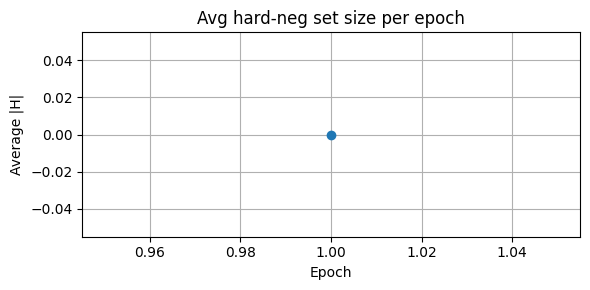

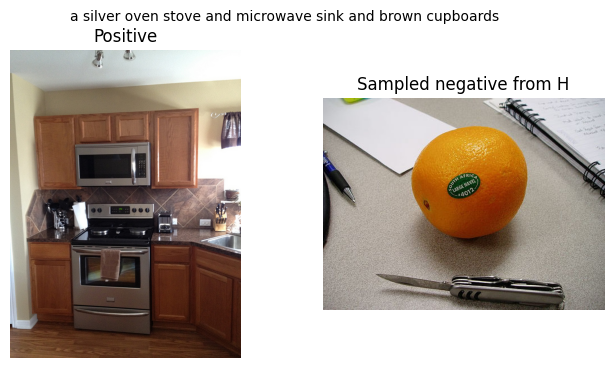

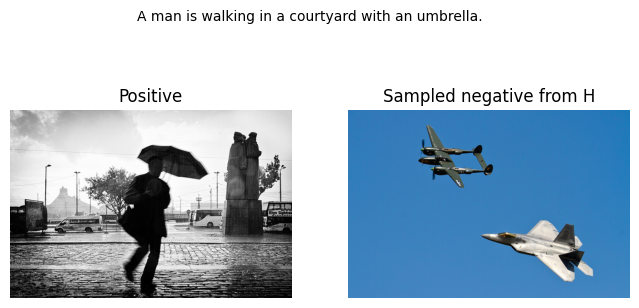

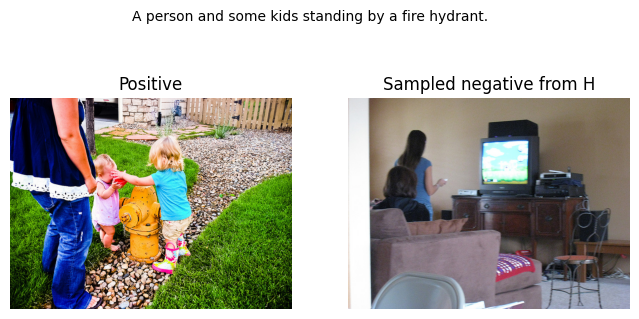


=== QuRE epoch 2 / 8 ===


Training batches: 100%|██████████| 1850/1850 [07:50<00:00,  3.93it/s]


Epoch 2 QuRE loss: 0.000151
Saved checkpoint: /content/drive/MyDrive/image_retrieval_phase1_coco/checkpoints_qure/qure_epoch2.pt


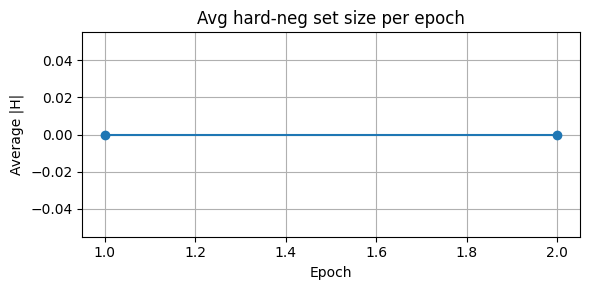

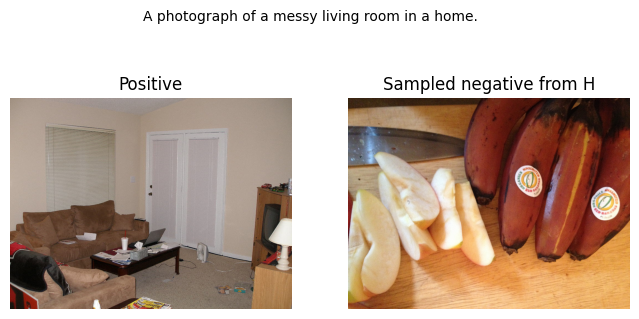

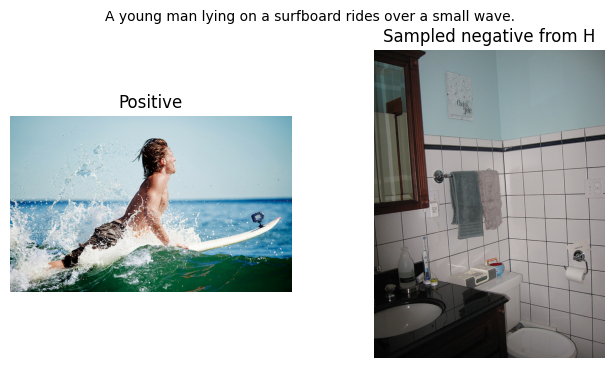

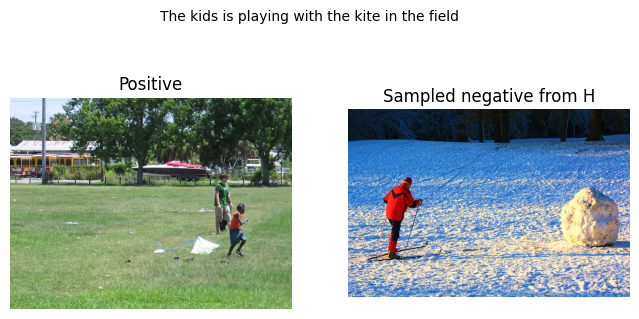


=== QuRE epoch 3 / 8 ===
Recomputing image embeddings and H sets (using current model)...


Encoding images:  15%|█▍        | 271/1849 [03:19<18:13,  1.44it/s]

In [ ]:
from matplotlib import pyplot as plt
import IPython.display as display

# Setup optimizer (start from current model weights or from scratch)
opt = torch.optim.AdamW(model.parameters(), lr=2e-5)  # smaller LR for continued training

# Precompute initial image_embs (already done above); ensure correct dtype
image_embs = compute_image_embeddings(model, unique_images, batch_size=64, device=device, force_recompute=False, cache_path=image_embs_path)

# We'll store H stats
epoch_H_sizes = []

# Determine recompute schedule
recompute_every = max(1, math.floor(NEPOCH / NDEF))

for epoch in range(NEPOCH):
    print("\n=== QuRE epoch", epoch+1, "/", NEPOCH, "===")
    # Recompute H sets according to schedule: warmup at epoch==0 (no H sets — uniform sampling),
    # otherwise recompute every `recompute_every` epochs (including epoch 1 if desired)
    recompute_now = (epoch == 0) or (epoch % recompute_every == 0 and epoch != 0)
    if recompute_now and epoch != 0:
        print("Recomputing image embeddings and H sets (using current model)...")
        image_embs = compute_image_embeddings(model, unique_images, batch_size=64, device=device, force_recompute=True, cache_path=image_embs_path)
        # Compute H sets for all training queries (df_small)
        H_sets = compute_all_H_sets(model, df_small, unique_images, image_embs, use_faiss_if_large=True, topk_faiss=TOPK_FALLBACK)
        with open(os.path.join(H_SAVE_DIR, f"hard_negatives_epoch_{epoch}.pkl"), "wb") as f:
            pickle.dump(H_sets, f)
        print("Saved H_sets for epoch", epoch)
    elif epoch == 0:
        print("Warmup epoch: sampling negatives uniformly from corpus (no H sets).")
        H_sets = None

    # Train through df_small in randomized order, sample 1 negative per query from H_sets (or uniform during warmup)
    model.train()
    total_loss = 0.0
    indices = list(df_small.index)
    random.shuffle(indices)
    for bi in tqdm(range(0, len(indices), BATCH_SIZE), desc="Training batches"):
        batch_idx = indices[bi:bi+BATCH_SIZE]
        # prepare batch pixels and texts
        pixs = []
        q_texts = []
        targ_idxs = []
        for idx_row in batch_idx:
            row = df_small.iloc[idx_row]
            pixs.append(img_transform(Image.open(row['image_path']).convert("RGB")))
            q_texts.append(str(row['text']))
            targ_idxs.append(int(row['target_idx']))
        pixs = torch.stack(pixs).to(device)
        toks = tokenizer(q_texts, padding=True, truncation=True, max_length=40, return_tensors="pt")
        ids = toks['input_ids'].to(device); attn = toks['attention_mask'].to(device)

        # compute embeddings
        t_emb = model.text_encoder(ids, attn)            # [B, D]
        i_emb_pos = model.img_encoder(pixs)              # [B, D]

        # sample negatives (image indices)
        neg_image_embs = []
        for local_i, global_idx in enumerate(batch_idx):
            if (epoch == 0) or (H_sets is None):
                # warmup: uniform random negative image index != target
                cand = random.randrange(num_images)
                while cand == targ_idxs[local_i]:
                    cand = random.randrange(num_images)
                neg_idx = cand
            else:
                H = H_sets[local_i] if (local_i < len(H_sets) and H_sets[local_i] is not None) else []
                if len(H) == 0:
                    cand = random.randrange(num_images)
                    while cand == targ_idxs[local_i]:
                        cand = random.randrange(num_images)
                    neg_idx = cand
                else:
                    neg_idx = random.choice(H)
            # use precomputed image_embs for negative
            neg_emb = torch.from_numpy(image_embs[neg_idx]).to(device)
            neg_image_embs.append(neg_emb)
        neg_image_embs = torch.stack(neg_image_embs).to(device)   # [B, D]

        # compute Bradley-Terry NLL loss: -log sigmoid(s_pos - s_neg)
        temp = model.temp
        s_pos = (t_emb * i_emb_pos).sum(-1) / temp
        s_neg = (t_emb * neg_image_embs).sum(-1) / temp
        loss = -torch.log(torch.sigmoid(s_pos - s_neg) + 1e-12).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    avg_loss = total_loss / (math.ceil(len(indices) / BATCH_SIZE))
    print(f"Epoch {epoch+1} QuRE loss: {avg_loss:.6f}")

    # Save model checkpoint and H_sets if present
    ckpt_path = os.path.join(CKPT_DIR, f"qure_epoch{epoch+1}.pt")
    torch.save(model.state_dict(), ckpt_path)
    print("Saved checkpoint:", ckpt_path)
    if H_sets is not None:
        with open(os.path.join(H_SAVE_DIR, f"hard_negatives_epoch_{epoch+1}.pkl"), "wb") as f:
            pickle.dump(H_sets, f)

    # === Visualization: average |H| plot and sample retrieved images ===
    # compute average H size (if computed)
    if H_sets is None:
        epoch_H_sizes.append(0)
    else:
        avg_h = np.mean([len(h) if h is not None else 0 for h in H_sets])
        epoch_H_sizes.append(avg_h)
    # Plot avg H sizes so far
    plt.figure(figsize=(6,3))
    plt.plot(range(1, len(epoch_H_sizes)+1), epoch_H_sizes, marker='o')
    plt.xlabel("Epoch"); plt.ylabel("Average |H|"); plt.title("Avg hard-neg set size per epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Show 3 example queries with their positive and one sampled hard negative
    n_examples = 3
    example_indices = random.sample(range(len(df_small)), k=n_examples)
    for ex_i in example_indices:
        row = df_small.iloc[ex_i]
        qtext = str(row['text'])
        pos_path = row['image_path']
        targ_idx = int(row['target_idx'])
        # pick a negative
        if H_sets is None or H_sets[ex_i] is None or len(H_sets[ex_i])==0:
            neg_idx = random.randrange(num_images)
            while neg_idx == targ_idx:
                neg_idx = random.randrange(num_images)
        else:
            neg_idx = random.choice(H_sets[ex_i])
        neg_path = unique_images[neg_idx]

        # display
        fig, axes = plt.subplots(1,2, figsize=(8,4))
        pos_img = Image.open(pos_path).convert("RGB")
        neg_img = Image.open(neg_path).convert("RGB")
        axes[0].imshow(pos_img); axes[0].set_title("Positive"); axes[0].axis('off')
        axes[1].imshow(neg_img); axes[1].set_title("Sampled negative from H"); axes[1].axis('off')
        plt.suptitle(qtext[:200], fontsize=10)
        plt.show()

print("QuRE training complete.")
